# Perseus smaller region 

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Perseus/'
name = 'perseus_s'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + 'HGBS_perseus_column_density_map_rebin_rot.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

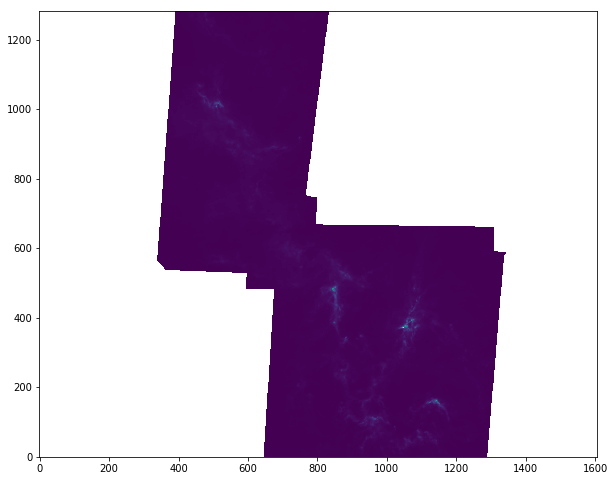

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to -1.598e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.236e+22 [aplpy.core]


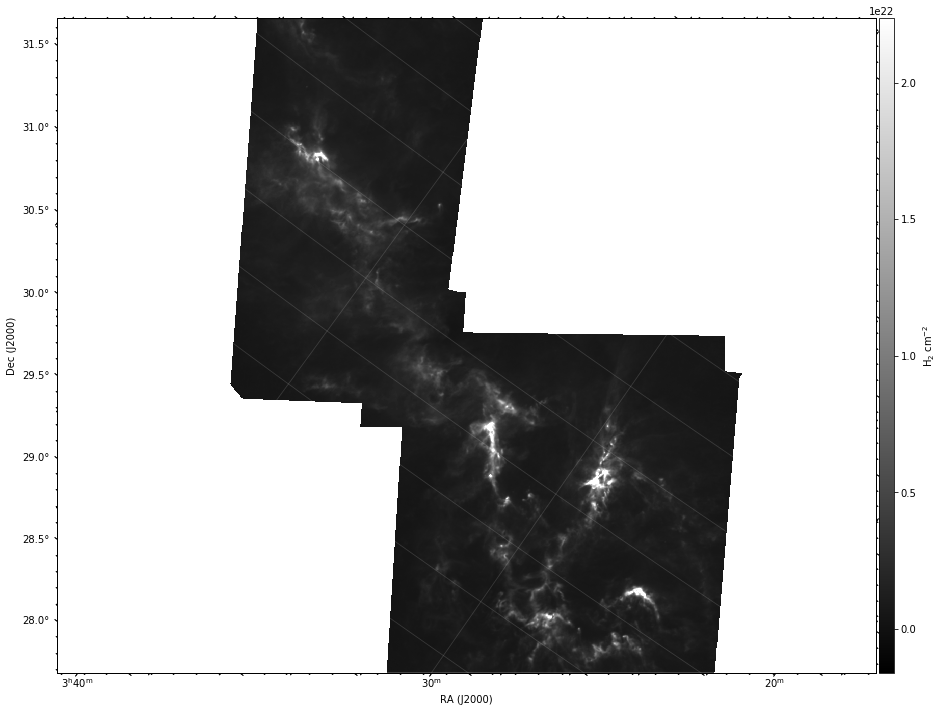

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [7]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

In [21]:
#Cut the map
input = path + 'HGBS_perseus_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([703,130,1020,310])
subfits(input,output,coords)

Dimensions 318 181


In [22]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -2.888e+20 [aplpy.core]
INFO: Auto-setting vmax to  8.891e+21 [aplpy.core]


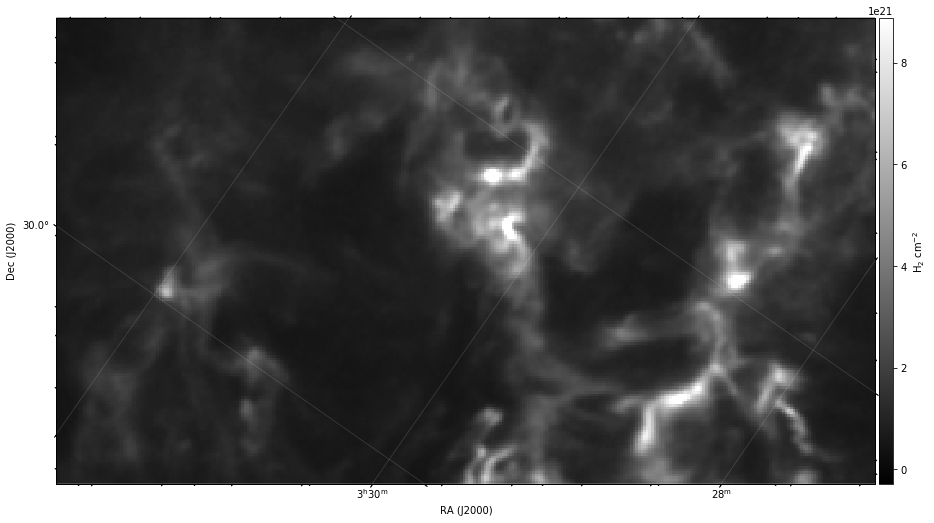

In [23]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [24]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((300,450))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [25]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

450 300


Text(0.5, 1.0, 'Beam power spectrum')

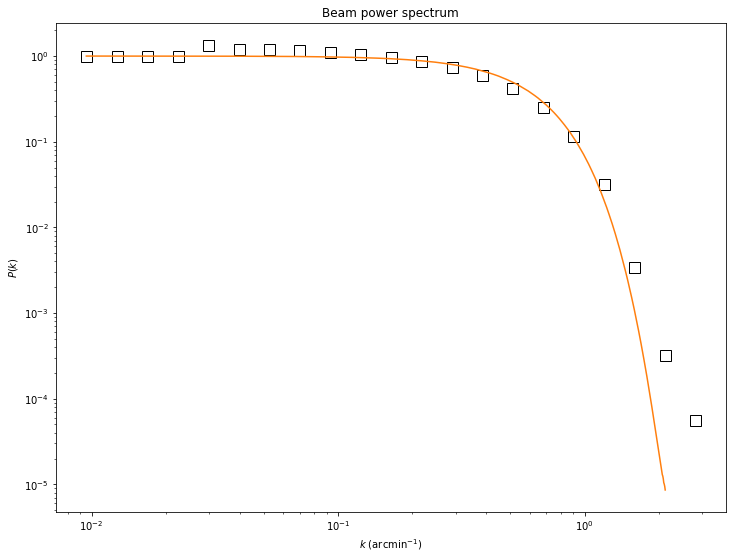

In [26]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  2.23593035655775e+41 -2.215638861560506 0.0
Gaussian wavelet
A, Gamma, P0 =  1.4768684003143e+39 -3.885685311494907 0.0


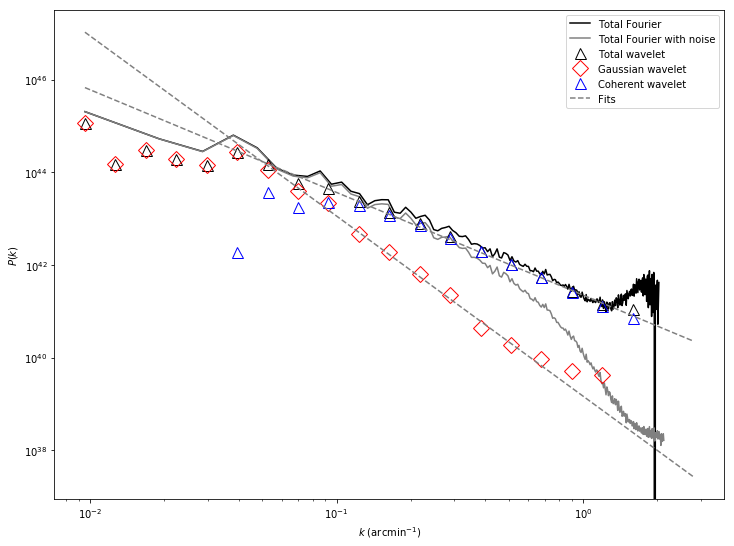

In [28]:
Noise = spec_k[-1]

#Power spectra fits
A_gauss, cov = np.polyfit(np.log(wav_k[6:15]), np.log(S1a[2,6:15]/BS1an[6:15]),deg=1,cov=True)
fit_gauss = np.exp(A_gauss[1])*wav_k**A_gauss[0]
A_cohe, cov = np.polyfit(np.log(wav_k[9:18]), np.log(S1a[1,9:18]/BS1an[9:18]),deg=1,cov=True)
fit_cohe = np.exp(A_cohe[1])*wav_k**A_cohe[0]

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', np.exp(A_cohe[1]), A_cohe[0], 0.)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', np.exp(A_gauss[1]), A_gauss[0], 0.)

plt.figure(figsize(12,9))
plt.plot(tab_k[:-10], (spec_k[:-10]-Noise)/spec_beamn2[:-10], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)
"""
x1=1.1
plt.plot([x1,x1],[1e38,1e44], ls=':', label=np.str(x1)+' arcmin$^{-1}$')
x2=0.57
plt.plot([x2,x2],[1e38,1e44], ls=':', label=np.str(x2)+' arcmin$^{-1}$')
"""
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

plt.savefig(path + 'HGBS_' + name + '_column_density_map_power_spec.png', dpi=500)